# $Z_3$ model for baryon physics

In [2]:
import numpy as np
import scipy
omega = np.exp(2j*np.pi/3)
V = np.array([[1,0,0],[0,omega,0],[0,0,omega**2]])
U = np.array([[0,1,0],[0,0,1],[1,0,0]])

%load_ext autoreload
%autoreload 2


In [3]:
# Building dense and sparse Kronecker-construction functions for placing a 3x3 operator V on a chosen site (or sites)
# in a chain of N sites (local dimension 3). 
# The operator space dimension is 3**N.
# Dense version uses numpy.kron, sparse version uses scipy.sparse.kron.
# Site indexing: 0-based (0 .. N-1). You can pass a single int or a list/tuple of ints for `sites`.
# The functions validate V shape and the sites list.
# Example usage demonstrated at the end.

import numpy as np

def kron_dense(factors):
    """Helper: compute Kronecker product of a list of dense arrays (left-to-right)."""
    from functools import reduce
    return reduce(np.kron, factors)

def op_on_sites_dense(V, N, sites):
    """
    Construct dense operator on (C^3)^{\otimes N} with operator V placed on the given `sites`.
    Parameters
    ----------
    V : array-like, shape (3,3)
        Local operator to place.
    N : int
        Number of sites (N >= 1).
    sites : int or sequence of ints
        Site index or list of site indices (0-based) where V is placed.
    Returns
    -------
    O : ndarray, shape (3**N, 3**N)
        The dense operator.
    """
    if V.shape != (3,3):
        raise ValueError("V must be a 3x3 matrix.")
    if N < 1 or int(N) != N:
        raise ValueError("N must be a positive integer.")
    if isinstance(sites, int):
        sites = [sites]
    sites = sorted(int(s) for s in sites)
    if any(s < 0 or s >= N for s in sites):
        raise IndexError("Site indices must be in range 0..N-1.")
    
    I3 = np.eye(3, dtype=V.dtype)
    factors = [(V if i in sites else I3) for i in range(N)]
    return kron_dense(factors)


# Sparse version
def op_on_sites_sparse(V, N, sites, format='csr'):
    """
    Construct sparse operator on (C^3)^{\otimes N} with operator V placed on the given `sites`.
    Returns a scipy.sparse matrix (by default CSR).
    """
    import scipy.sparse as sp

    V = sp.csr_matrix(V) if not sp.issparse(V) else V.tocsr()
    if V.shape != (3,3):
        raise ValueError("V must be a 3x3 matrix or sparse 3x3.")
    if N < 1 or int(N) != N:
        raise ValueError("N must be a positive integer.")
    if isinstance(sites, int):
        sites = [sites]
    sites = sorted(int(s) for s in sites)
    if any(s < 0 or s >= N for s in sites):
        raise IndexError("Site indices must be in range 0..N-1.")

    I3 = sp.eye(3, format='csr', dtype=V.dtype)
    result = None
    # left-to-right Kronecker (site 0 is the leftmost factor)
    for i in range(N):
        factor = V if i in sites else I3
        if result is None:
            result = factor
        else:
            result = sp.kron(result, factor, format='csr')
    if format != 'csr':
        result = result.asformat(format)
    return result

In [48]:
from qs_mps.lattice import Lattice
from scipy.sparse import identity, csr_array

class H_Z3_gauss:
    def __init__(
        self,
        Lx,
        Ly,
        model: str,
        lamb: float = 0,
        J: float = 1,
        G: float = 1e3,
    ):
        self.Lx = Lx
        self.Ly = Ly
        self.model = model
        self.charges = np.ones((Ly, Lx+1), dtype=np.complex128)
        self.lamb = lamb
        self.J = J
        self.G = G
        self.latt = Lattice((self.Lx+1, self.Ly), (False, True))
        self.dof = self.latt.nlinks
        self.sector = self._define_sector()

    def add_charges(self, rows: list, columns: list, vals: list):
        """
        add_charges

        This function adds the charges to the background
        vacuum sector (all positive charges). The number of
        charges we add are given by the len of each indices list

        rows: list - row indices of the charges to add
        columns: list - column indices of the charges to add
        """
        for i, j, q in zip(rows, columns, vals):
            self.charges[j, i] = q

        # self.charges = np.flip(self.charges, axis=0)
        return self

    def _define_sector(self):
        particles = 0
        for charge in self.charges.flatten():
            if charge != 1:
                particles += 1

        if particles == 0:
            sector = "vacuum_sector"
        else:
            sector = f"{particles}_particle(s)_sector"
            self.sector = sector
        return sector

    def local_term(self, link):
        sigma_x = op_on_sites_sparse(V, sites=link, N=self.latt.nlinks)
        return sigma_x

    def plaquette_term(self, loop):
        plaq = op_on_sites_sparse(U, sites=loop[0], N=self.latt.nlinks) @ op_on_sites_sparse(U, sites=loop[1], N=self.latt.nlinks) @ op_on_sites_sparse(U.conjugate().T, sites=loop[2], N=self.latt.nlinks) @ op_on_sites_sparse(U.conjugate().T, sites=loop[3], N=self.latt.nlinks)
        return plaq

    def gauge_constraint(self, site):
        links = self.latt.star(site=site, Lx=self.Lx, Ly=self.Ly)
        G = identity(n=3**self.latt.nlinks)
        filtered_links = [element for element in links if element != 0]
        # print("links:")
        # print(site, filtered_links)
        for i, link in enumerate(filtered_links):
            if site[0] < self.Lx:
                if i == 0 or i == 1:
                    op = V.copy()
                elif i == 2 or i == 3:
                    op = V.conjugate().T.copy()
            elif site[0] == self.Lx:
                if i == 0:
                    op = V.copy()
                elif i > 0:
                    op = V.conjugate().T.copy()

            G = G @ op_on_sites_sparse(op, sites=link - 1, N=self.latt.nlinks)

        return G

    def hamiltonian(self):
        loc = csr_array((3**self.latt.nlinks, 3**self.latt.nlinks))
        # local terms
        for link in range(self.latt.nlinks):
            loc += self.local_term(link)

        plaq = csr_array((3**self.latt.nlinks, 3**self.latt.nlinks))
        # plaquette terms
        for loop in self.latt.plaquettes(from_zero=True):
            plaq += self.plaquette_term(loop)

        # gauge constraint
        Gauss = 0
        I = identity(n=3**self.latt.nlinks)
        for site in self.latt.sites:
            # print(site)
            g = self.gauge_constraint(site)
            Gauss += (g - self.charges[site[1], site[0]] * I) @ (
                g - self.charges[site[1], site[0]] * I
            )
        return - (self.J * loc) - (self.lamb * plaq) + (self.G * Gauss)

    def diagonalize(
        self,
        v0: np.ndarray = None,
        sparse: bool = True,
        save: bool = False,
        path: str = None,
        precision: int = 2,
        spectrum: str = "gs",
        cx: list = None,
        cy: list = None,
    ):
        H = self.hamiltonian()

        if sparse:
            if spectrum == "all":
                k = 2 ** len(self.latt.plaquettes())
            elif spectrum == "gs":
                k = 1
            e, v = scipy.sparse.linalg.eigsh(H, k=k, which="SA", v0=v0)
        else:
            H = H.toarray()
            e, v = np.linalg.eigh(H)
        if save:
            # print(self.sector)
            np.save(
                path
                + f"/results/eigenvectors/ground_state_direct_lattice_{self.l-1}x{self.L-1}_{self.sector}_{cx}-{cy}_U_{self.G}_hG{self.lamb:.{precision}f}.npy",
                v[:, 0],
            )
        return e, v

### utils functions

In [49]:
def magnetization(Lx, Ly):
    dof = 2 * Lx * Ly + Ly
    mag = csr_array((3**dof, 3**dof))
    for site in range(dof):
        mag += op_on_sites_sparse(V, N=dof, sites=site)
    return mag

### $2$ charges (of different type)

In [50]:
Lx = 2
Ly = 2
cx = [0,2]
cy = [0,0]
vals = [omega, omega**2]
Z3_baryon = H_Z3_gauss(Lx, Ly, model="Z3", lamb=0.1, J=1)
print(Z3_baryon.charges, Z3_baryon.latt.sites)
Z3_baryon.add_charges([0,2],[0,0],[omega, omega**2])
print(Z3_baryon.charges)
print(Z3_baryon.latt._lattice_drawer.draw_lattice())

[[1.+0.j 1.+0.j 1.+0.j]
 [1.+0.j 1.+0.j 1.+0.j]] [(0, 0), (0, 1), (1, 0), (1, 1), (2, 0), (2, 1)]
[[-0.5+0.8660254j  1. +0.j        -0.5-0.8660254j]
 [ 1. +0.j         1. +0.j         1. +0.j       ]]
      8      9      10
      |      |      |      
      +-- 3--+-- 4--+      
      |      |      |      
      5      6      7 
      |      |      |      
      +-- 1--+-- 2--+      
      |      |      |      
      8      9      10



In [51]:
e, v = Z3_baryon.diagonalize()

In [52]:
M = magnetization(Lx, Ly)
print((csr_array(v).conjugate().T @ M @ csr_array(v)).toarray())
dof = 2 * Lx * Ly + Ly
loc_mag = []
for site in range(dof):
    loc_mag.append((csr_array(v).conjugate().T @ op_on_sites_sparse(V, N=dof, sites=site) @ csr_array(v)).toarray()[0])

shape_el_field = (2 * Ly, 2 * Lx + 1)
E_h = np.zeros(shape_el_field, dtype=np.complex128)
E_h[:] = np.nan
horizontal_links = np.asarray(loc_mag[0:Lx*Ly]).reshape((Ly,Lx))
vertical_links = np.asarray(loc_mag[Lx*Ly::]).reshape((Ly,Lx+1))
E_h[0::2,1::2] = horizontal_links
E_h[1::2,0::2] = vertical_links
phase = np.angle(E_h) % (2*np.pi)

print(horizontal_links, vertical_links, phase)

[[6.99999999-1.7320508j]]
[[-0.5-8.66025403e-01j -0.5-8.66025401e-01j]
 [ 1. -8.02274843e-11j  1. -9.59368503e-13j]] [[1.+3.20718879e-10j 1.+7.20903931e-10j 1.-9.60435957e-10j]
 [1.+2.40491394e-10j 1.+6.39717079e-10j 1.-9.61395326e-10j]] [[           nan 4.18879020e+00            nan 4.18879020e+00
             nan]
 [3.20718879e-10            nan 7.20903933e-10            nan
  6.28318531e+00]
 [           nan 6.28318531e+00            nan 6.28318531e+00
             nan]
 [2.40491394e-10            nan 6.39717080e-10            nan
  6.28318531e+00]]


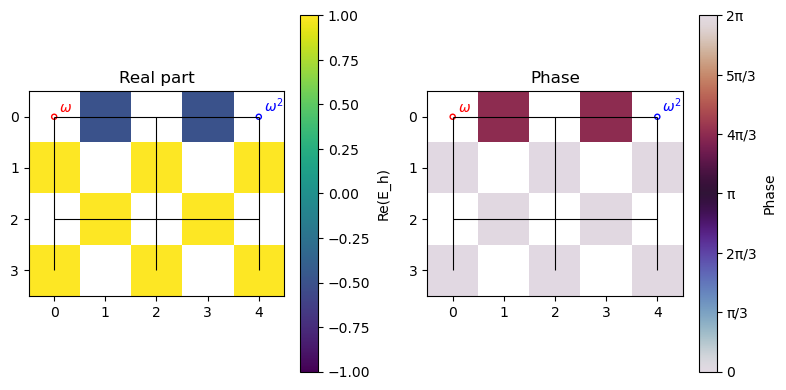

In [53]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from matplotlib.patches import Ellipse

fig, ax = plt.subplots(1, 2, figsize=(8,4))

# First panel: real part of E_h
im_real = ax[0].imshow(E_h.real, cmap="viridis", vmin=-1, vmax=1)
ax[0].set_title("Real part")
cbar_real = fig.colorbar(im_real, ax=ax[0])
cbar_real.set_label("Re(E_h)")

# Second panel: Z3 phase
im = ax[1].imshow(phase, cmap='twilight', vmin=0, vmax=2*np.pi)
ax[1].set_title("Phase")

# Colorbar
cbar = fig.colorbar(im, ax=ax[1])

# choose tick locations: here every π/3
ticks = np.arange(0, 2*np.pi + 1e-6, np.pi/3)
cbar.set_ticks(ticks)

def pi_formatter(x, pos):
    """Format tick x (in radians) as a multiple of π with nice fractions."""
    n = np.round(x/np.pi*3)   # integers for thirds of π
    # map integer counts of π/3 to string labels
    labels = {
        0: "0",
        1: "π/3",
        2: "2π/3",
        3: "π",
        4: "4π/3",
        5: "5π/3",
        6: "2π"
    }
    return labels.get(int(n), "")

cbar.ax.yaxis.set_major_formatter(FuncFormatter(pi_formatter))
cbar.set_label("Phase")

# create the lattice
hlines = list(range(E_h.shape[0]))[::2]
vlines = list(range(E_h.shape[1]))[::2]
for idx in range(2):
    ax[idx].hlines(y=hlines, xmin=0, xmax=E_h.shape[1] - 1, colors="k", linewidth=0.8)
    ax[idx].vlines(x=vlines, ymin=0, ymax=E_h.shape[0] - 1, colors="k", linewidth=0.8)

    # add charges
    if cx != None:
        for i in range(len(cx)):
            if vals[i] == omega:
                q = "$\omega$"
                color = "red"
            elif vals[i] == omega**2:
                q = "$\omega^2$"
                color = "blue"
                
            ax[idx].text(
                x=2 * cx[i] + 0.1, y=2 * cy[i] - 0.1, s=q, color=color
            )
            circle = Ellipse(
                (2 * cx[i], 2 * cy[i]),
                0.1,
                0.1,
                edgecolor=color,
                facecolor="none",
                linewidth=1,
            )
            ax[idx].add_patch(circle)

plt.tight_layout()
plt.show()

### $3$ charges (as quarks uud or ddu)

In [54]:
cx = [0,0,2]
cy = [1,0,1]
vals = [omega**2, omega, omega]
Z3_baryon = H_Z3_gauss(Lx, Ly, model="Z3",  J=1, lamb=1e-2, G=1e+4)
print(Z3_baryon.charges, Z3_baryon.latt.sites)
Z3_baryon.add_charges(cx,cy,vals)
print(Z3_baryon.charges)

[[1.+0.j 1.+0.j 1.+0.j]
 [1.+0.j 1.+0.j 1.+0.j]] [(0, 0), (0, 1), (1, 0), (1, 1), (2, 0), (2, 1)]
[[-0.5+0.8660254j  1. +0.j         1. +0.j       ]
 [-0.5-0.8660254j  1. +0.j        -0.5+0.8660254j]]


In [55]:
e, v = Z3_baryon.diagonalize()

In [56]:
M = magnetization(Lx, Ly)
print((csr_array(v).conjugate().T @ M @ csr_array(v)).toarray())
dof = 2 * Lx * Ly + Ly
loc_mag = []
for site in range(dof):
    loc_mag.append((csr_array(v).conjugate().T @ op_on_sites_sparse(V, N=dof, sites=site) @ csr_array(v)).toarray()[0,0])

print(loc_mag)
shape_el_field = (2 * Ly, 2 * Lx + 1)
E_h = np.zeros(shape_el_field, dtype=np.complex128)
E_h[:] = np.nan
horizontal_links = np.asarray(loc_mag[0:Lx*Ly]).reshape((Ly,Lx))
vertical_links = np.asarray(loc_mag[Lx*Ly::]).reshape((Ly,Lx+1))
E_h[0::2,1::2] = horizontal_links
E_h[1::2,0::2] = vertical_links
phase = np.angle(E_h) % (2*np.pi)

print(horizontal_links)
print(vertical_links)
print(phase)

[[7.-1.73205081j]]
[(1.0000000001888592+1.3231010356530516e-14j), (1.0000000001885838+5.449748955403889e-16j), (1.0000000001888592-1.3231010356540307e-14j), (1.00000000018858+3.2675440249292083e-15j), (-0.5000000000944174-0.8660254039480222j), (1.0000000001887328+8.419980949648107e-14j), (1.0000000001887508-9.589220914895272e-14j), (1.000000000188899+1.0830154975516345e-14j), (1.000000000188707+6.927091255557317e-14j), (-0.500000000094452-0.8660254039478508j)]
[[1.+1.32310104e-14j 1.+5.44974896e-16j]
 [1.-1.32310104e-14j 1.+3.26754402e-15j]]
[[-0.5-8.66025404e-01j  1. +8.41998095e-14j  1. -9.58922091e-14j]
 [ 1. +1.08301550e-14j  1. +6.92709126e-14j -0.5-8.66025404e-01j]]
[[           nan 1.32310104e-14            nan 5.44974895e-16
             nan]
 [4.18879020e+00            nan 8.41998095e-14            nan
  6.28318531e+00]
 [           nan 6.28318531e+00            nan 3.26754402e-15
             nan]
 [1.08301550e-14            nan 6.92709125e-14            nan
  4.18879020e+00]

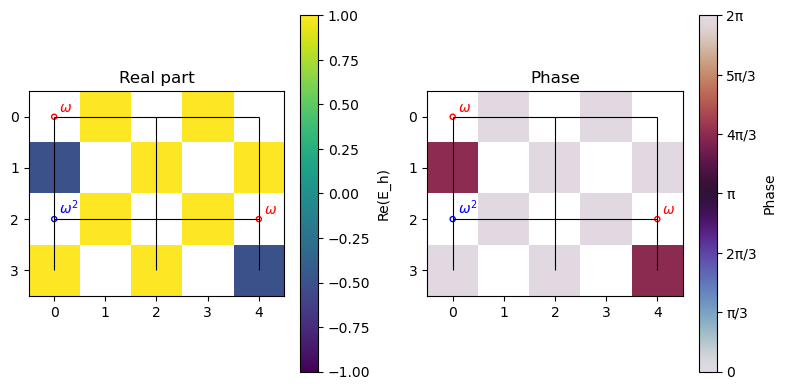

In [57]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from matplotlib.patches import Ellipse

fig, ax = plt.subplots(1, 2, figsize=(8,4))

# First panel: real part of E_h
im_real = ax[0].imshow(E_h.real, cmap="viridis", vmin=-1, vmax=1)
ax[0].set_title("Real part")
cbar_real = fig.colorbar(im_real, ax=ax[0])
cbar_real.set_label("Re(E_h)")

# Second panel: Z3 phase
im = ax[1].imshow(phase, cmap='twilight', vmin=0, vmax=2*np.pi)
ax[1].set_title("Phase")

# Colorbar
cbar = fig.colorbar(im, ax=ax[1])

# choose tick locations: here every π/3
ticks = np.arange(0, 2*np.pi + 1e-6, np.pi/3)
cbar.set_ticks(ticks)

def pi_formatter(x, pos):
    """Format tick x (in radians) as a multiple of π with nice fractions."""
    n = np.round(x/np.pi*3)   # integers for thirds of π
    # map integer counts of π/3 to string labels
    labels = {
        0: "0",
        1: "π/3",
        2: "2π/3",
        3: "π",
        4: "4π/3",
        5: "5π/3",
        6: "2π"
    }
    return labels.get(int(n), "")

cbar.ax.yaxis.set_major_formatter(FuncFormatter(pi_formatter))
cbar.set_label("Phase")

# create the lattice
hlines = list(range(E_h.shape[0]))[::2]
vlines = list(range(E_h.shape[1]))[::2]
for idx in range(2):
    ax[idx].hlines(y=hlines, xmin=0, xmax=E_h.shape[1] - 1, colors="k", linewidth=0.8)
    ax[idx].vlines(x=vlines, ymin=0, ymax=E_h.shape[0] - 1, colors="k", linewidth=0.8)

    # add charges
    if cx != None:
        for i in range(len(cx)):
            if vals[i] == omega:
                q = "$\omega$"
                color = "red"
            elif vals[i] == omega**2:
                q = "$\omega^2$"
                color = "blue"
                
            ax[idx].text(
                x=2 * cx[i] + 0.1, y=2 * cy[i] - 0.1, s=q, color=color
            )
            circle = Ellipse(
                (2 * cx[i], 2 * cy[i]),
                0.1,
                0.1,
                edgecolor=color,
                facecolor="none",
                linewidth=1,
            )
            ax[idx].add_patch(circle)

plt.tight_layout()
plt.show()

## Explore the phase diagram

In [ ]:
Lx = 2
Ly = 2
dof = 2 * Lx * Ly + Ly
cx = [0,0,2]
cy = [1,0,1]
h_i, h_f, npoints = -1, 1, 20
vals = [omega**2, omega, omega]
M = magnetization(Lx, Ly)
shape_el_field = (2 * Ly, 2 * Lx + 1)
E_h = np.zeros(shape_el_field, dtype=np.complex128)

tot_field = np.zeros((npoints, *E_h.shape), dtype=np.complex128)
tot_phase = np.zeros((npoints, *E_h.shape))
tot_field[:] = np.nan
tot_phase[:] = np.nan
idx = 0
for lamb in np.logspace(h_i,h_f,npoints):
    print("# ===============")
    print(f"lambda: {lamb:.3f}")
    Z3_baryon = H_Z3_gauss(Lx, Ly, model="Z3", lamb=lamb)
    Z3_baryon.add_charges(cx,cy,vals)
    print("diagonalizing...")
    e, v = Z3_baryon.diagonalize()
    loc_mag_lamb = []
    print("finding local magnetization...")
    for site in range(dof):
        loc_mag_lamb.append((csr_array(v).conjugate().T @ op_on_sites_sparse(V, N=dof, sites=site) @ csr_array(v)).toarray()[0,0])

    E_h[:] = np.nan
    horizontal_links = np.asarray(loc_mag_lamb[0:Lx*Ly]).reshape((Ly,Lx))
    vertical_links = np.asarray(loc_mag_lamb[Lx*Ly::]).reshape((Ly,Lx+1))
    E_h[0::2,1::2] = horizontal_links
    E_h[1::2,0::2] = vertical_links
    phase = np.angle(E_h) % (2*np.pi)
    print

    print("saving arrays...")
    tot_field[idx] = E_h
    tot_phase[idx] = phase
    idx += 1

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from matplotlib.patches import Ellipse
from matplotlib.animation import FuncAnimation

def animate_lattice(tot_E_h, tot_phase, cx=None, cy=None, vals=None, omega=None, interval=500):
    """
    Animate a lattice of E_h and Z3 phases.
    
    Parameters
    ----------
    tot_E_h   : ndarray, shape (n_frames, nx, ny) -- real part of E_h
    tot_phase : ndarray, shape (n_frames, nx, ny) -- phase array (0..2π)
    cx, cy    : list of charge positions (same length as vals)
    vals      : list of charge values (same length as cx, cy)
    omega     : complex, the Z3 omega root
    interval  : int, ms between frames
    """
    n_frames, nx, ny = tot_E_h.shape
    
    fig, ax = plt.subplots(1, 2, figsize=(8,4))

    # Initial plots
    im_real = ax[0].imshow(tot_E_h[0].real, cmap="viridis", vmin=-1, vmax=1)
    ax[0].set_title("Real part")
    cbar_real = fig.colorbar(im_real, ax=ax[0])
    cbar_real.set_label("Re(E_h)")
    
    im_phase = ax[1].imshow(tot_phase[0], cmap='twilight', vmin=0, vmax=2*np.pi)
    ax[1].set_title("Phase")
    cbar_phase = fig.colorbar(im_phase, ax=ax[1])

    # Phase colorbar ticks in multiples of π
    ticks = np.arange(0, 2*np.pi + 1e-6, np.pi/3)
    cbar_phase.set_ticks(ticks)
    def pi_formatter(x, pos):
        n = np.round(x/np.pi*3)
        labels = {0:"0",1:"π/3",2:"2π/3",3:"π",4:"4π/3",5:"5π/3",6:"2π"}
        return labels.get(int(n),"")
    cbar_phase.ax.yaxis.set_major_formatter(FuncFormatter(pi_formatter))
    cbar_phase.set_label("Phase")

    # Draw lattice once (assuming same size for all frames)
    hlines = list(range(nx))[::2]
    vlines = list(range(ny))[::2]
    for a in ax:
        a.hlines(y=hlines, xmin=0, xmax=ny-1, colors="k", linewidth=0.8)
        a.vlines(x=vlines, ymin=0, ymax=nx-1, colors="k", linewidth=0.8)

    # For charges, we create empty lists to store patches and texts
    text_objects = []
    circle_objects = []
    if cx is not None:
        for i in range(len(cx)):
            # Placeholders
            text = ax[1].text(0,0,"", color="black")
            text_objects.append(text)
            circ = Ellipse((0,0), 0.1, 0.1, edgecolor="black", facecolor="none", linewidth=1)
            ax[1].add_patch(circ)
            circle_objects.append(circ)

    # Update function for animation
    def update(frame):
        im_real.set_data(tot_E_h[frame].real)
        im_phase.set_data(tot_phase[frame])
        
        if cx is not None:
            for i in range(len(cx)):
                if vals[i] == omega:
                    q = "$\omega$"
                    color = "red"
                elif vals[i] == omega**2:
                    q = "$\omega^2$"
                    color = "blue"
                else:
                    q = ""
                    color = "black"
                
                x, y = 2*cx[i], 2*cy[i]
                text_objects[i].set_position((x+0.1, y-0.1))
                text_objects[i].set_text(q)
                text_objects[i].set_color(color)
                
                circle_objects[i].set_center((x, y))
                circle_objects[i].set_edgecolor(color)

        return [im_real, im_phase] + text_objects + circle_objects

    anim = FuncAnimation(fig, update, frames=n_frames, interval=interval, blit=True)
    plt.tight_layout()
    return anim

<>:71: SyntaxWarning: invalid escape sequence '\o'
<>:74: SyntaxWarning: invalid escape sequence '\o'
<>:71: SyntaxWarning: invalid escape sequence '\o'
<>:74: SyntaxWarning: invalid escape sequence '\o'
C:\Users\HP\AppData\Local\Temp\ipykernel_26064\330812209.py:71: SyntaxWarning: invalid escape sequence '\o'
  q = "$\omega$"
C:\Users\HP\AppData\Local\Temp\ipykernel_26064\330812209.py:74: SyntaxWarning: invalid escape sequence '\o'
  q = "$\omega^2$"


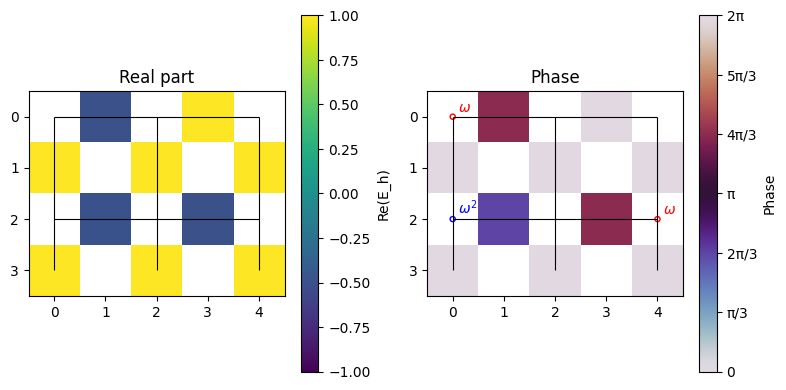

In [ ]:
# Example
anim = animate_lattice(tot_field, tot_phase, cx=cx, cy=cy, vals=vals, omega=omega, interval=500)

# To display in Jupyter
from IPython.display import HTML
HTML(anim.to_jshtml())